In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow --quiet

Epoch 1/50
28/28 [==============================] - 5s 64ms/step - loss: 0.1292 - val_loss: 0.0051
Epoch 2/50
28/28 [==============================] - 1s 31ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 3/50
28/28 [==============================] - 1s 18ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 4/50
28/28 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 5/50
28/28 [==============================] - 1s 18ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 6/50
28/28 [==============================] - 1s 19ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 7/50
28/28 [==============================] - 1s 19ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 8/50
28/28 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 9/50
28/28 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 10/50
28/28 [==============================] - 1s 20ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 11/

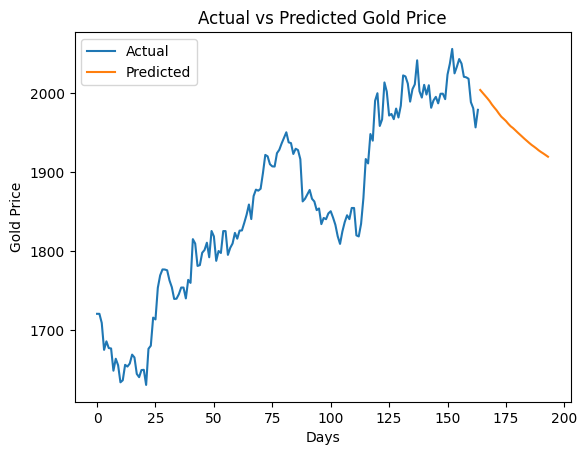

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate, Flatten
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv")

# Format column Price to float
data['Price'] = data.Price.str.replace(',','').astype(float)

# Flip the column
data = data.iloc[::-1]

# Chuyển cột datetime thành kiểu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sắp xếp theo thứ tự thời gian
data = data.sort_values('Date')

# Chia dữ liệu thành train, validation và test
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data['Price'].values.reshape(-1, 1))
scaled_val = scaler.transform(val_data['Price'].values.reshape(-1, 1))
scaled_test = scaler.transform(test_data['Price'].values.reshape(-1, 1))

# Tạo dữ liệu huấn luyện và kiểm tra
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data)-lookback-1):
        X.append(data[i:(i+lookback), 0])
        y.append(data[i+lookback, 0])
    return np.array(X), np.array(y)

lookback = 30  # Độ dài cửa sổ trượt
X_train, y_train = create_dataset(scaled_train, lookback)
X_val, y_val = create_dataset(scaled_val, lookback)
X_test, y_test = create_dataset(scaled_test, lookback)

# Xây dựng mô hình LSTM with Attention
inputs = Input(shape=(lookback, 1))
lstm_out = LSTM(64, return_sequences=True)(inputs)
attention = Dense(1, activation='tanh')(lstm_out)
attention = Activation('softmax')(attention)
context_vector = Dot(axes=1)([attention, lstm_out])
context_vector_flat = Flatten()(context_vector)
lstm_out_flat = Flatten()(lstm_out)
concat = Concatenate()([context_vector_flat, lstm_out_flat])
output = Dense(1)(concat)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam')


# Huấn luyện mô hình
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

# Dự đoán giá Vàng cho 30 ngày tiếp theo
future_predictions = []
last_sequence = X_test[-1]
for _ in range(30):
    next_pred = model.predict(last_sequence.reshape(1, lookback, 1))
    future_predictions.append(next_pred[0])
    last_sequence = np.append(last_sequence[1:], next_pred[0])

# Đảo chuẩn hóa dữ liệu để có giá trị thực tế
actual_test = scaler.inverse_transform(scaled_test[lookback+1:])
future_predictions = scaler.inverse_transform(np.array(future_predictions))

# Trực quan hóa kết quả
plt.plot(actual_test, label='Actual')
plt.plot(range(len(actual_test), len(actual_test)+len(future_predictions)), future_predictions, label='Predicted')
plt.xlabel('Days')
plt.ylabel('Gold Price')
plt.title('Actual vs Predicted Gold Price')
plt.legend()
plt.show()

In [19]:
print(future_predictions)

[[2003.8094]
 [2000.3285]
 [1996.9047]
 [1993.4688]
 [1989.7974]
 [1985.4004]
 [1981.6647]
 [1978.1244]
 [1973.9103]
 [1970.111 ]
 [1967.3815]
 [1964.5807]
 [1961.0867]
 [1957.9717]
 [1955.705 ]
 [1952.9294]
 [1950.0879]
 [1947.3774]
 [1944.6586]
 [1941.936 ]
 [1939.3625]
 [1936.7473]
 [1934.3175]
 [1932.1973]
 [1929.9521]
 [1927.5078]
 [1925.4154]
 [1923.5226]
 [1921.4916]
 [1919.418 ]]


In [3]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [4]:
# Read in the HPG dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv")
#set the date as the index
df=df.set_index(pd.DatetimeIndex(df['Date'].values))

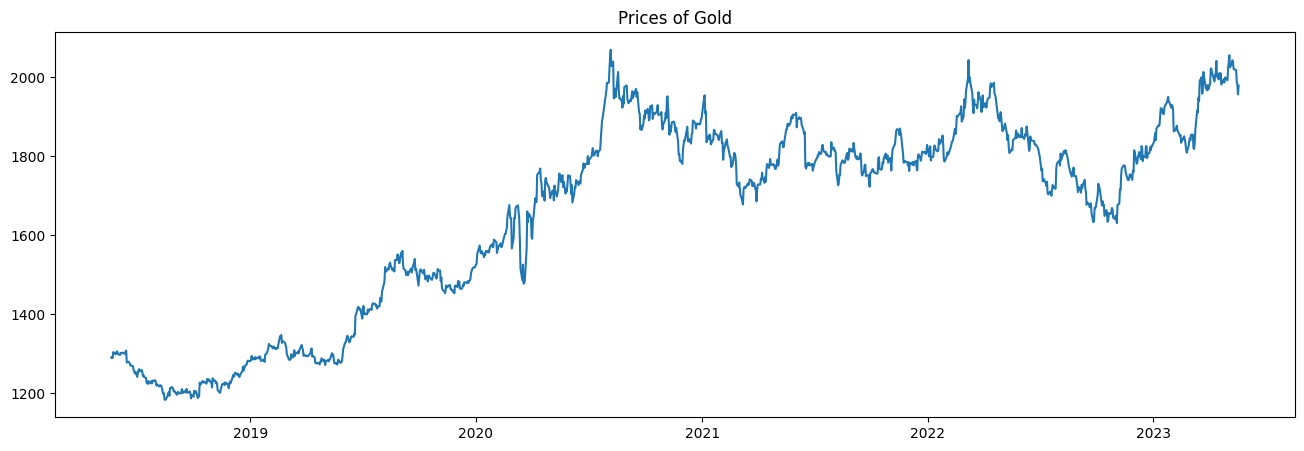

In [5]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Price'])
plt.title('Prices of Gold')
plt.show()

In [6]:
# Convert the 'df1' DataFrame to a NumPy array
data = df1.values

# Split the data
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [7]:
# Create a MinMaxScaler object with a specified range
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

In [8]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [9]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [14]:
def rnn_attention_model(input_shape, rnn_type='lstm', units=64):
    X_input = Input(shape=input_shape)
    
    if rnn_type.lower() == 'lstm':
        rnn_layer = LSTM(units, return_sequences=True)
    elif rnn_type.lower() == 'gru':
        rnn_layer = GRU(units, return_sequences=True)
    else:
        raise ValueError("Invalid RNN type. Choose 'lstm' or 'gru'.")

    rnn_output = rnn_layer(X_input)
    
    attention = Dense(1, activation='tanh')(rnn_output)
    attention = Activation('softmax')(attention)
    context = Dot(axes=1)([attention, rnn_output])

    concatenated = Concatenate(axis=-1)([context, X_input])
    
    output = Dense(1, activation='sigmoid')(concatenated)

    model = Model(inputs=X_input, outputs=output)
    
    return model

In [ ]:
# Build the model
# model.add(Attention())

model = Sequential()
model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# Add an LSTM layer with 128 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
# model.add(LSTM(units=64, input_shape=(x_train.shape[1], 1), return_sequences=True,kernel_regularizer=l2(0.01)))

# # Add an LSTM layer with 64 units
# model.add(LSTM(units=64, return_sequences=True))

# # Add an LSTM layer with 64 units
# model.add(LSTM(units=64, return_sequences=False))

# # Add a dropout layer with a rate of 0.5
# model.add(Dropout(0.5))

# # Add a dense layer with 1 unit
# model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

In [ ]:
 y_pred_test = model.predict(test_data, verbose=0)

In [ ]:
sc_train.shape

(1296, 1)

In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[1291:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

(1, 5)


In [ ]:
# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

[0.9419471425344477, 0.9085159250056472, 0.8998192907160605, 0.8724870115202168, 0.8975604246668172]


In [ ]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 31):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.8713542819023132], [0.8503435850143433], [0.8313980102539062], [0.8096156716346741], [0.7927565574645996], [0.775903582572937], [0.7597428560256958], [0.7444970011711121], [0.7295049428939819], [0.7151476144790649], [0.7012833952903748], [0.6878679394721985], [0.6749188899993896], [0.6623705625534058], [0.6502097249031067], [0.6384128332138062], [0.6269552111625671], [0.6158210039138794], [0.6049911975860596], [0.5944499969482422], [0.5841829180717468], [0.574176013469696], [0.5644169449806213], [0.5548939108848572], [0.5455961227416992], [0.5365135669708252], [0.5276368260383606], [0.5189573764801025], [0.5104668140411377], [0.5021578073501587], [0.4940232038497925]]


In [ ]:
import datetime as dt

# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=31, freq='1d').tolist()

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[1955.4970812 ]
 [1936.89421017]
 [1920.11979828]
 [1900.83371567]
 [1885.90665598]
 [1870.98503201]
 [1856.67632473]
 [1843.17764484]
 [1829.90367644]
 [1817.19169786]
 [1804.91631819]
 [1793.03827361]
 [1781.57318521]
 [1770.46289608]
 [1759.69569043]
 [1749.25072253]
 [1739.10614396]
 [1729.24791687]
 [1719.65920634]
 [1710.3260273 ]
 [1701.23555566]
 [1692.37544233]
 [1683.73476309]
 [1675.3030687 ]
 [1667.07080708]
 [1659.0291122 ]
 [1651.16964577]
 [1643.48486114]
 [1635.96731715]
 [1628.61052263]
 [1621.40814469]]


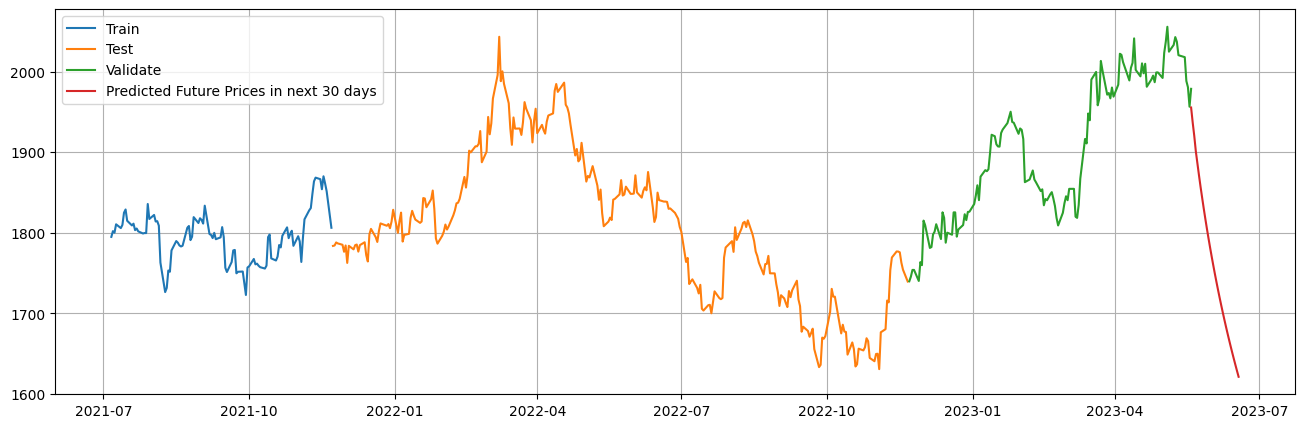

In [ ]:
# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:], label='Train')
plt.plot(test_data, label='Test')
plt.plot()
plt.plot(val_data, label='Validate')
plt.plot(PREDICTIONS_FUTURE, label='Predicted Future Prices in next 30 days')

# # Add a vertical line at the start of the future predictions
# plt.axvline(x=min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

# Add a legend and grid
plt.legend()
plt.grid()

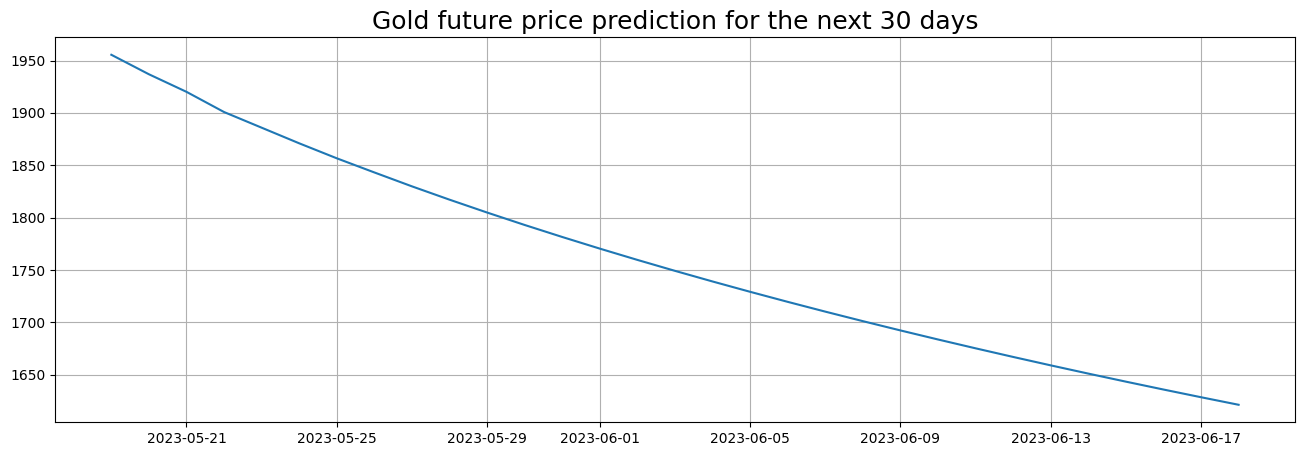

In [ ]:
# Set the figure size and create a subplot
plt.figure(figsize=(16,5))
plt.plot(PREDICTIONS_FUTURE)
# Add a legend and grid
plt.title('Gold future price prediction for the next 30 days',fontsize=18)
plt.grid()

In [ ]:
print(PREDICTIONS_FUTURE)

                  price
2023-05-19  1955.497081
2023-05-20  1936.894210
2023-05-21  1920.119798
2023-05-22  1900.833716
2023-05-23  1885.906656
2023-05-24  1870.985032
2023-05-25  1856.676325
2023-05-26  1843.177645
2023-05-27  1829.903676
2023-05-28  1817.191698
2023-05-29  1804.916318
2023-05-30  1793.038274
2023-05-31  1781.573185
2023-06-01  1770.462896
2023-06-02  1759.695690
2023-06-03  1749.250723
2023-06-04  1739.106144
2023-06-05  1729.247917
2023-06-06  1719.659206
2023-06-07  1710.326027
2023-06-08  1701.235556
2023-06-09  1692.375442
2023-06-10  1683.734763
2023-06-11  1675.303069
2023-06-12  1667.070807
2023-06-13  1659.029112
2023-06-14  1651.169646
2023-06-15  1643.484861
2023-06-16  1635.967317
2023-06-17  1628.610523
2023-06-18  1621.408145
